# What are people watching on Netflix?
Who?
Where?
Why?


`imports`, I've seen this before!

In [49]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime
from collections import defaultdict

Some magic that tells jupyter to put graphs and things in the notebook instead of the default behaviour which is to save it as a file.

In [50]:
%matplotlib inline

Set the size of the plots that will come out when we ask for them. Annoyingly, these are in inches. Whatever an "inch" is

In [51]:
plt.rcParams["figure.figsize"] = (10, 5)


In [52]:
saved_style_state = matplotlib.rcParams.copy()  # give us a style state to go back to


The following checks to see if we've already downloaded the data. It's a big file, so we don't want to do it every time we run the code. Even just loading from file takes a few seconds!

Pandas is pretty smart, it can get data from the internet just as easily as from the file system, it just takes a bit longer.

# Accessing the file

In [196]:
if os.path.isfile("all-weeks-countries.csv"):
    filepath = "all-weeks-countries.csv"
    print("loading from file")
else:
    filepath = "https://www.kaggle.com/datasets/dhruvildave/netflix-top-10-tv-shows-and-films?resource=download&select=all-weeks-countries.csv"
    print("loading from the internet")

netflix_data = pd.read_csv(filepath)

print("done")


loading from file
done


## Example row

In [197]:
netflix_data.iloc[0]

country_name                       Argentina
country_iso2                              AR
week                              2022-08-21
category                               Films
weekly_rank                                1
show_title                    Look Both Ways
season_title                             NaN
cumulative_weeks_in_top_10                 1
Name: 0, dtype: object

# Creating a function to get movie genres

In [198]:
import requests

api_key = 'c60cd8e6dfbc3c4bfb0b63eda3108351'
base_url = 'https://api.themoviedb.org/3'

def get_genre(show_title, category):
    if category == 'Films':
        search_url = f"{base_url}/search/movie"
    elif category == 'TV':
        search_url = f"{base_url}/search/tv"
    else:
        return 'Unknown'

    params = {
        'api_key': api_key,
        'query': show_title
    }

    response = requests.get(search_url, params=params)
    results = response.json().get('results', [])
    
    if results:
        show_id = results[0]['id']
        if category == 'Films':
            show_details_url = f"{base_url}/movie/{show_id}"
        else:
            show_details_url = f"{base_url}/tv/{show_id}"
        
        show_details_response = requests.get(show_details_url, params={'api_key': api_key})
        show_details = show_details_response.json()
        genres = show_details.get('genres', [])
        genre_names = [genre['name'] for genre in genres]
        return genre_names
    else:
        return 'Unknown'

# TRYING TO MAKE A DICTIONARY OF GENRES

In [199]:
import json

unique_titles = netflix_data['show_title'].unique()
genres_dict = {}

if os.path.isfile("./genre_file.json"):
        file = open("./genre_file.json", "r")
        genres_dict = json.load(file)
else:
    for title in unique_titles:
        category = netflix_data[netflix_data['show_title'] == title]['category'].iloc[0]
        genres = get_genre(title, category)
        genres_dict[title] = genres
    with open("genre_file.json","w") as file:
        json.dump(genres_dict, file, indent=4)

# Add the genres into the original csv

In [200]:
netflix_data['genres']=netflix_data['show_title'].map(genres_dict)
netflix_data.to_csv('all-weeks-countries.csv', index=False)

netflix_data.replace('Unknown', '', inplace=True)
netflix_data.to_csv('all-weeks-countries.csv', index=False)

## NEW Example Row

In [201]:
netflix_data.iloc[0]

country_name                                 Argentina
country_iso2                                        AR
week                                        2022-08-21
category                                         Films
weekly_rank                                          1
show_title                              Look Both Ways
season_title                                       NaN
cumulative_weeks_in_top_10                           1
genres                        [Romance, Drama, Comedy]
Name: 0, dtype: object

# Counting how much drama shows each country has

In [203]:
current_high=0
for name, df in netflix_data.groupby("country_name"):
    df = df.dropna(subset=['genres'])
    mask = [ 'Drama' in genres for genres in df['genres'] ]
    dramatic = df[mask]
    if len(dramatic)>=current_high:
        current_high=len(dramatic)
        dramatic_country=name
print (f"{dramatic_country} is the MOST DRAMATIC COUNTRY!! They watched {current_high} drama shows. ") 

current_low=10000
for name, df in netflix_data.groupby("country_name"):
    mask = [ 'Drama' in genres for genres in df['genres'] ]
    dramatic = df[mask]
    if len(dramatic)<=current_low:
        current_low=len(dramatic)
        xdramatic_country=name
print (f"{xdramatic_country} is the LEAST DRAMATIC COUNTRY!! They watched {current_low} drama shows")

Indonesia is the MOST DRAMATIC COUNTRY!! They watched 782 drama shows. 
Russia is the LEAST DRAMATIC COUNTRY!! They watched 423 drama shows


In [204]:
current_high=0
for name, df in netflix_data.groupby("country_name"):
    mask = [ 'Comedy' in genres for genres in df['genres'] ]
    funny = df[mask]
    if len(funny)>=current_high:
        current_high=len(funny)
        funny_country=name
print (f"{funny_country} is the MOST FUNNY COUNTRY!! They watched {current_high} comedy shows")

current_low=10000
for name, df in netflix_data.groupby("country_name"):
    mask = [ 'Comedy' in genres for genres in df['genres'] ]
    funny = df[mask]
    if len(funny)<=current_low:
        current_low=len(funny)
        xfunny_country=name
print (f"{xfunny_country} is the LEAST FUNNY COUNTRY!! They watched {current_low} comedy shows")

Latvia is the MOST FUNNY COUNTRY!! They watched 480 comedy shows
Russia is the LEAST FUNNY COUNTRY!! They watched 221 comedy shows


# Create ranking

## Drama

In [206]:
current_high=0
dramatic_dict=[]
for name, df in netflix_data.groupby("country_name"):
    mask = [ 'Drama' in genres for genres in df['genres'] ]
    dramatic = df[mask]
    dramatic_dict.append({'country_name': name, 'drama_count': len(dramatic)})

dramatic_df = pd.DataFrame(dramatic_dict)
sorted_dramatic_df = dramatic_df.sort_values(by='drama_count',ascending=False)
print(sorted_dramatic_df.to_string(index=False)) #convert a DataFrame or Series into a string representation

        country_name  drama_count
           Indonesia          782
                Oman          780
             Nigeria          772
           Sri Lanka          763
              Taiwan          757
             Romania          752
               Italy          746
         Philippines          746
           Argentina          743
            Portugal          740
               Chile          739
            Pakistan          739
           Venezuela          739
          Bangladesh          736
           Nicaragua          734
                Peru          734
             Uruguay          731
          Costa Rica          730
            Paraguay          729
             Morocco          729
             Vietnam          728
              Serbia          722
            Malaysia          721
            Honduras          721
             Ukraine          720
        Saudi Arabia          719
               Malta          718
               Qatar          715
              

## Comedy

In [207]:
current_high=0
funny_dict=[]
for name, df in netflix_data.groupby("country_name"):
    mask = [ 'Comedy' in genres for genres in df['genres'] ]
    funny = df[mask]
    funny_dict.append({'country_name': name, 'funny_count': len(funny)})

funny_df = pd.DataFrame(funny_dict)
sorted_funny_df = funny_df.sort_values(by='funny_count',ascending=False)
print(sorted_funny_df.to_string(index=False)) #convert a DataFrame or Series into a string representation

        country_name  funny_count
              Latvia          480
           Lithuania          463
             Bolivia          457
              Jordan          452
             Estonia          417
           Guatemala          415
            Slovenia          407
            Honduras          406
            Thailand          406
         El Salvador          402
             Vietnam          398
          Costa Rica          395
            Colombia          394
              Mexico          392
             Ecuador          391
           Nicaragua          382
             Croatia          374
               Chile          372
              Cyprus          372
              Serbia          371
                Peru          369
             Ukraine          369
            Slovakia          368
              Panama          367
            Malaysia          365
             Iceland          364
      Czech Republic          361
              Turkey          360
            Bu

## Romance

In [208]:
current_high=0
romantic_dict=[]
for name, df in netflix_data.groupby("country_name"):
    mask = [ 'Romance' in genres for genres in df['genres'] ]
    romance = df[mask]
    romantic_dict.append({'country_name': name, 'romantic_count': len(romance)})

romantic_df = pd.DataFrame(romantic_dict)
sorted_romantic_df = romantic_df.sort_values(by='romantic_count',ascending=False)
print(sorted_romantic_df.to_string(index=False)) #convert a DataFrame or Series into a string representation

        country_name  romantic_count
             Lebanon             164
           Lithuania             160
              Serbia             152
             Hungary             148
            Bulgaria             147
             Romania             146
            Portugal             146
               India             143
              Greece             141
            Slovenia             137
             Croatia             136
              Poland             136
          Martinique             135
           Mauritius             135
               Italy             134
           Sri Lanka             134
         Switzerland             134
              Latvia             133
          Guadeloupe             133
               Spain             132
             Nigeria             130
              Cyprus             129
        South Africa             127
               Malta             127
             Estonia             124
            Honduras             124
 

## Action

In [209]:
current_high=0
action_dict=[]
for name, df in netflix_data.groupby("country_name"):
    mask = [ 'Action' in genres for genres in df['genres'] ]
    action = df[mask]
    action_dict.append({'country_name': name, 'action_count': len(action)})

action_df = pd.DataFrame(action_dict)
sorted_action_df = action_df.sort_values(by='action_count',ascending=False)
print(sorted_action_df.to_string(index=False))

        country_name  action_count
             Vietnam           349
         South Korea           290
           Singapore           282
           Hong Kong           278
            Malaysia           277
            Thailand           275
             Jamaica           268
        Saudi Arabia           261
       New Caledonia           258
           Indonesia           255
         Philippines           254
                Oman           247
               Qatar           244
              Taiwan           243
            Pakistan           243
              Israel           239
              Kuwait           238
 Trinidad and Tobago           238
               Japan           237
             Réunion           237
               Kenya           236
United Arab Emirates           236
             Belgium           233
             Morocco           233
  Dominican Republic           233
         New Zealand           232
              Jordan           230
              Cyprus

# Why is Russia always last?

In [214]:
russia_data=netflix_data[netflix_data['country_name']=='Russia']
print(f'Russia has {len(russia_data)} entries')

us_data=netflix_data[netflix_data['country_name']=='United States']
print(f'United States has {len(us_data)} entries')

Russia has 700 entries
United States has 1200 entries


# Redefining the time range

In [215]:
netflix_data=netflix_data[netflix_data['week']<='2022-02-27']

# Create NEW ranking

## Drama

In [216]:
current_high=0
dramatic_dict=[]
for name, df in netflix_data.groupby("country_name"):
    mask = [ 'Drama' in genres for genres in df['genres'] ]
    dramatic = df[mask]
    dramatic_dict.append({'country_name': name, 'drama_count': len(dramatic)})

dramatic_df = pd.DataFrame(dramatic_dict)
sorted_dramatic_df = dramatic_df.sort_values(by='drama_count',ascending=False)
print(sorted_dramatic_df.to_string(index=False)) #convert a DataFrame or Series into a string representation

        country_name  drama_count
              Taiwan          460
           Venezuela          456
                Oman          456
           Indonesia          452
             Nigeria          450
           Argentina          449
               Chile          443
           Sri Lanka          441
           Nicaragua          441
             Morocco          441
          Costa Rica          439
          Bangladesh          438
         Philippines          438
             Vietnam          436
             Uruguay          435
            Paraguay          434
            Pakistan          433
            Honduras          433
            Portugal          432
                Peru          430
               Italy          427
               Malta          427
         El Salvador          426
              Russia          423
               India          422
  Dominican Republic          421
             Romania          421
            Malaysia          420
             B

## Comedy

In [217]:
current_high=0
funny_dict=[]
for name, df in netflix_data.groupby("country_name"):
    mask = [ 'Comedy' in genres for genres in df['genres'] ]
    funny = df[mask]
    funny_dict.append({'country_name': name, 'funny_count': len(funny)})

funny_df = pd.DataFrame(funny_dict)
sorted_funny_df = funny_df.sort_values(by='funny_count',ascending=False)
print(sorted_funny_df.to_string(index=False)) #convert a DataFrame or Series into a string representation

        country_name  funny_count
              Latvia          331
           Lithuania          329
             Estonia          302
            Slovenia          289
             Bolivia          284
              Jordan          274
             Vietnam          270
           Guatemala          269
              Mexico          262
            Colombia          262
             Croatia          259
            Thailand          255
          Costa Rica          254
            Honduras          252
              Serbia          251
             Ecuador          249
            Bulgaria          247
             Iceland          246
         El Salvador          245
           Nicaragua          244
            Slovakia          241
      United Kingdom          241
              Panama          240
               Chile          235
           Indonesia          235
            Paraguay          234
             Ukraine          233
      Czech Republic          232
              

## Romance

In [218]:
current_high=0
romantic_dict=[]
for name, df in netflix_data.groupby("country_name"):
    mask = [ 'Romance' in genres for genres in df['genres'] ]
    romance = df[mask]
    romantic_dict.append({'country_name': name, 'romantic_count': len(romance)})

romantic_df = pd.DataFrame(romantic_dict)
sorted_romantic_df = romantic_df.sort_values(by='romantic_count',ascending=False)
print(sorted_romantic_df.to_string(index=False)) #convert a DataFrame or Series into a string representation

        country_name  romantic_count
               India             107
          Bangladesh              90
           Sri Lanka              88
             Lebanon              86
           Mauritius              83
            Maldives              83
             Nigeria              78
            Pakistan              77
           Lithuania              77
             Romania              77
            Bulgaria              75
              Serbia              75
             Hungary              74
        South Africa              71
          Martinique              71
           Nicaragua              70
             Croatia              70
          Guadeloupe              70
            Paraguay              69
               Italy              69
            Honduras              69
              Cyprus              68
            Portugal              68
            Slovenia              68
 Trinidad and Tobago              68
           Guatemala              67
 

## Action

In [219]:
current_high=0
action_dict=[]
for name, df in netflix_data.groupby("country_name"):
    mask = [ 'Action' in genres for genres in df['genres'] ]
    action = df[mask]
    action_dict.append({'country_name': name, 'action_count': len(action)})

action_df = pd.DataFrame(action_dict)
sorted_action_df = action_df.sort_values(by='action_count',ascending=False)
print(sorted_action_df.to_string(index=False))

        country_name  action_count
             Vietnam           205
           Hong Kong           183
           Singapore           179
            Thailand           174
         South Korea           167
            Malaysia           167
             Jamaica           161
       New Caledonia           160
           Indonesia           159
            Pakistan           159
        Saudi Arabia           157
               Qatar           155
         Philippines           154
                Oman           154
              Taiwan           153
United Arab Emirates           152
              Kuwait           148
              Jordan           148
              Israel           145
 Trinidad and Tobago           144
               Japan           143
           Mauritius           142
             Réunion           141
               Kenya           139
             Morocco           139
             Belgium           139
             Estonia           139
             Iceland

# Create map

# Dealing with some names

In [220]:
# Create a mapping dictionary to eliminate name discrepancies
name_mapping = {
    'United States': 'United States of America', 'Serbia': 'Republic of Serbia','Czech Republic':'Czechia', 'Bahamas':'The Bahamas'}

# Apply the mapping to your DataFrame
dramatic_df['country_name'] = dramatic_df['country_name'].map(name_mapping).fillna(dramatic_df['country_name'])
missing_in_world = dramatic_df[~dramatic_df['country_name'].isin(world['SOVEREIGNT'])]

print("Missing in world GeoDataFrame:")
print(missing_in_world)

Missing in world GeoDataFrame:
     country_name  drama_count
27     Guadeloupe          403
30      Hong Kong          415
50     Martinique          399
55  New Caledonia          401
71        Réunion          383


In [221]:
missing_in_df = world[~world['SOVEREIGNT'].isin(dramatic_df['country_name'])]

print("Missing in dramatic_df:")
print(missing_in_df[['SOVEREIGNT']])

Missing in dramatic_df:
      SOVEREIGNT
0       Zimbabwe
1         Zambia
2          Yemen
5        Vatican
6        Vanuatu
..           ...
236      Albania
237  Afghanistan
238      Kashmir
239   Antarctica
241       Tuvalu

[114 rows x 1 columns]


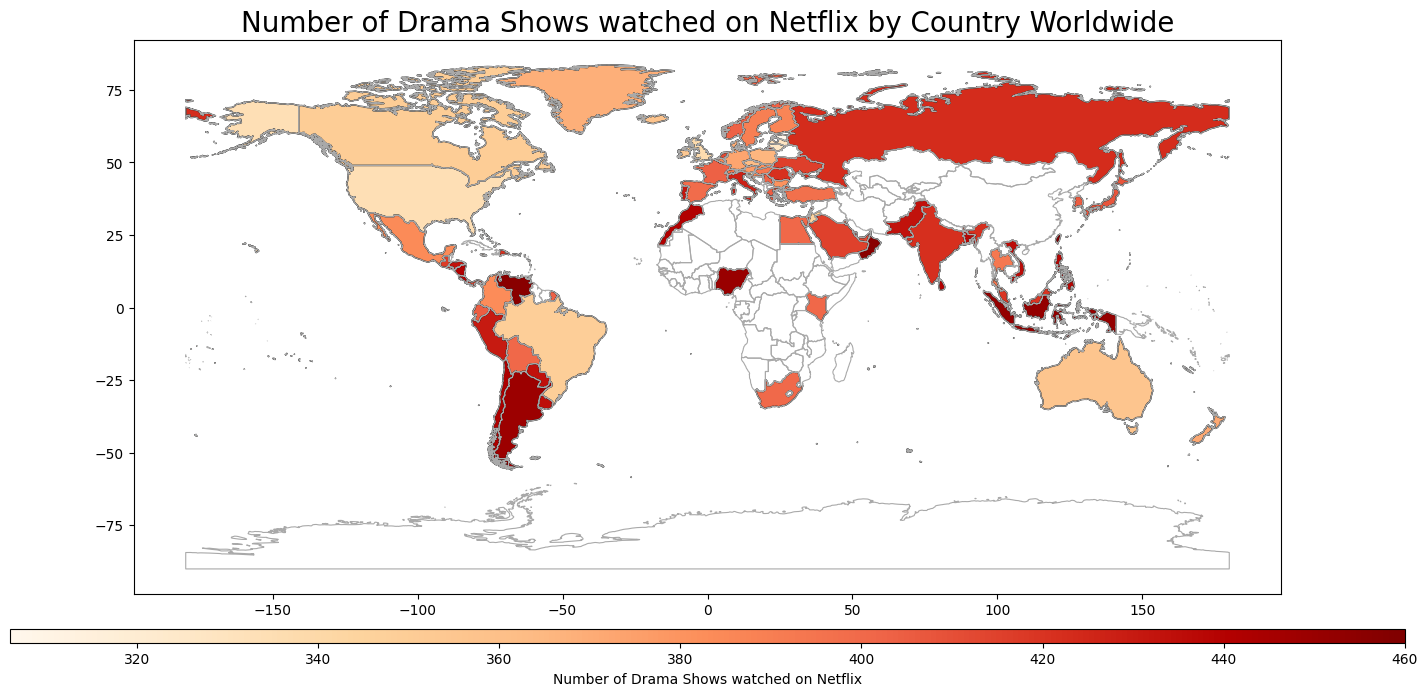

In [222]:
import geopandas as gpd
world = gpd.read_file('/Users/denyceng/CODE1161dataproject/ne_50m_admin_0_countries')

# merges the world GeoDataFrame with another DataFrame called dramatic_df. 
# The merge is done on the columns 'SOVEREIGNT' from world and 'country_name' from dramatic_df. 
# The how='left' argument means that all rows from the world dataset will be retained, and only matching rows from dramatic_df will be added
world = world.merge(dramatic_df, left_on='SOVEREIGNT', right_on='country_name', how='left') #

fig, ax = plt.subplots(1, 1, figsize=(18, 9)) #creates a Matplotlib figure (fig) and a set of axes (ax).
world.boundary.plot(ax=ax,edgecolor= 'darkgray',lw=0.8) #plots the boundaries of the geometries from GeoDataFrame on axes. This step outlines the countries borders.
world.plot(column='drama_count', #specifies the column in the GeoDataFrame to use for coloring the map. Here, it's likely a count of drama shows.
           ax=ax,
           legend=True, #adds a legend (colorbar) to the plot
           cmap='OrRd', #sets the colormap to "Orange-Red,"
           edgecolor='black',
           legend_kwds={'label': "Number of Drama Shows watched on Netflix",
                        'orientation': "horizontal",'pad':0.05, 'aspect':100, 'spacing':'proportional'}) # It sets the label of the colorbar and makes the orientation of the legend horizontal.
ax.tick_params(axis='both', labelsize=10) #sets the font size of the tick labels on X and Y axis to 45.

plt.title('Number of Drama Shows watched on Netflix by Country Worldwide',fontsize=20)
plt.show()

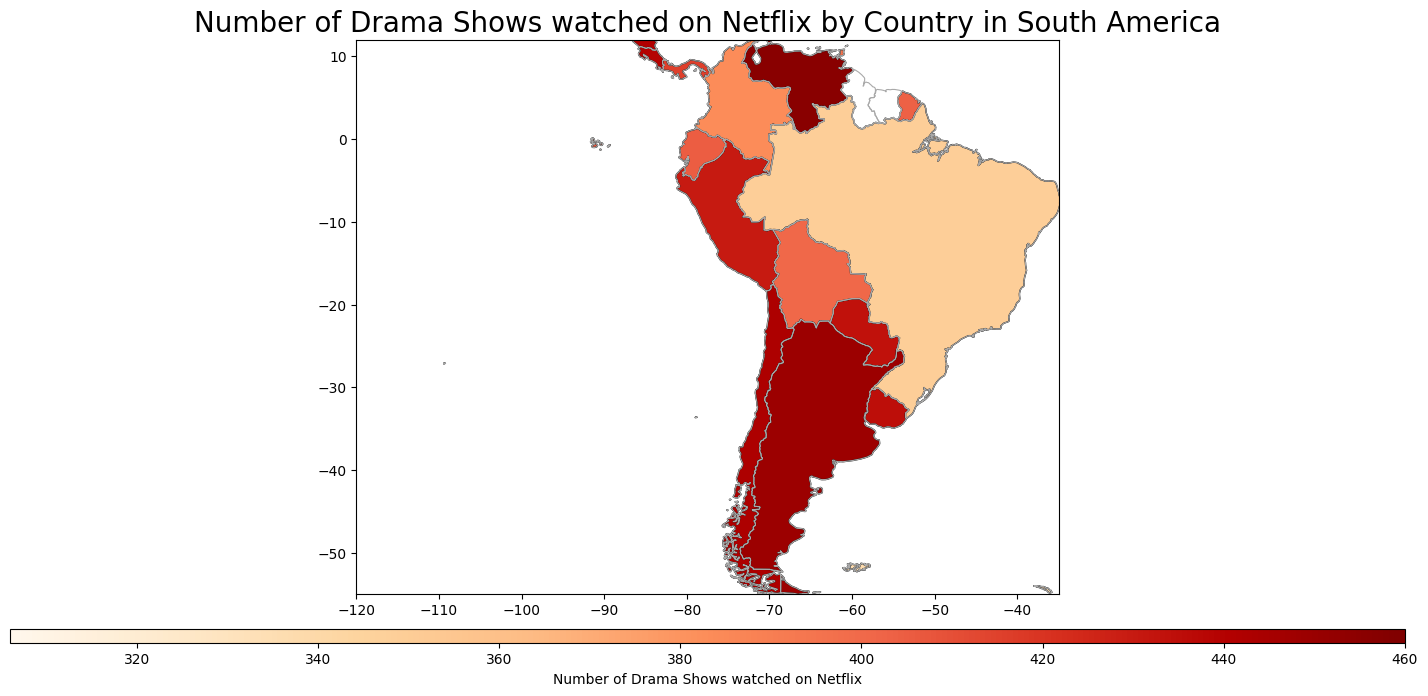

In [223]:

world = gpd.read_file('/Users/denyceng/CODE1161dataproject/ne_50m_admin_0_countries')

# merges the world GeoDataFrame with another DataFrame called dramatic_df. 
# The merge is done on the columns 'SOVEREIGNT' from world and 'country_name' from dramatic_df. 
# The how='left' argument means that all rows from the world dataset will be retained, and only matching rows from dramatic_df will be added
world = world.merge(dramatic_df, left_on='SOVEREIGNT', right_on='country_name', how='left') #

fig, ax = plt.subplots(1, 1, figsize=(18, 9)) #creates a Matplotlib figure (fig) and a set of axes (ax).
world.boundary.plot(ax=ax,edgecolor= 'darkgray',lw=0.8) #plots the boundaries of the geometries from GeoDataFrame on axes. This step outlines the countries borders.
world.plot(column='drama_count', #specifies the column in the GeoDataFrame to use for coloring the map. Here, it's likely a count of drama shows.
           ax=ax,
           legend=True, #adds a legend (colorbar) to the plot
           cmap='OrRd', #sets the colormap to "Orange-Red,"
           edgecolor='black',
           legend_kwds={'label': "Number of Drama Shows watched on Netflix",
                        'orientation': "horizontal",'pad':0.05, 'aspect':100, 'spacing':'proportional'}) # It sets the label of the colorbar and makes the orientation of the legend horizontal.
ax.tick_params(axis='both', labelsize=10) #sets the font size of the tick labels on X and Y axis to 45.
ax.set_ylim([-55, 12])  # Longitude range for continent
ax.set_xlim([-120, -35])
plt.title('Number of Drama Shows watched on Netflix by Country in South America',fontsize=20)
plt.show()

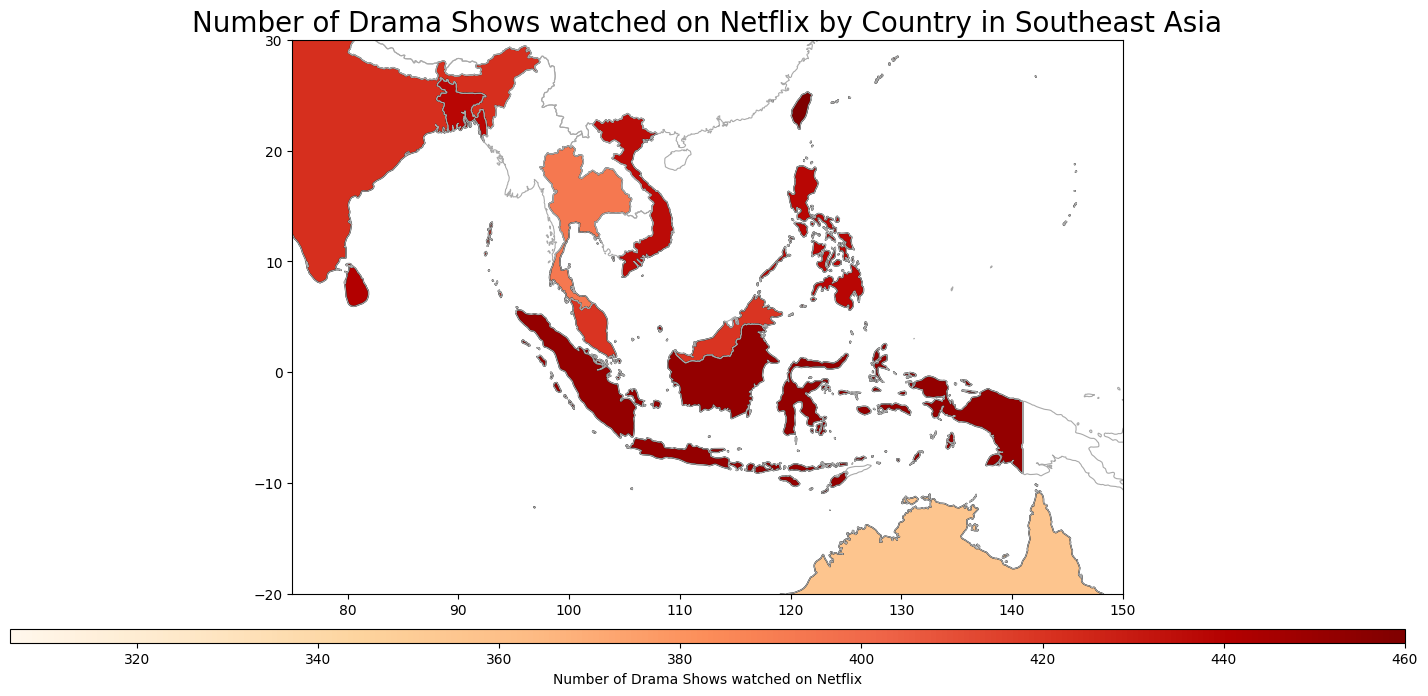

In [224]:

world = gpd.read_file('/Users/denyceng/CODE1161dataproject/ne_50m_admin_0_countries')

# merges the world GeoDataFrame with another DataFrame called dramatic_df. 
# The merge is done on the columns 'SOVEREIGNT' from world and 'country_name' from dramatic_df. 
# The how='left' argument means that all rows from the world dataset will be retained, and only matching rows from dramatic_df will be added
world = world.merge(dramatic_df, left_on='SOVEREIGNT', right_on='country_name', how='left') #

fig, ax = plt.subplots(1, 1, figsize=(18, 9)) #creates a Matplotlib figure (fig) and a set of axes (ax).
world.boundary.plot(ax=ax,edgecolor= 'darkgray',lw=0.8) #plots the boundaries of the geometries from GeoDataFrame on axes. This step outlines the countries borders.
world.plot(column='drama_count', #specifies the column in the GeoDataFrame to use for coloring the map. Here, it's likely a count of drama shows.
           ax=ax,
           legend=True, #adds a legend (colorbar) to the plot
           cmap='OrRd', #sets the colormap to "Orange-Red,"
           edgecolor='black',
           legend_kwds={'label': "Number of Drama Shows watched on Netflix",
                        'orientation': "horizontal",'pad':0.05, 'aspect':100, 'spacing':'proportional'}) # It sets the label of the colorbar and makes the orientation of the legend horizontal.
ax.tick_params(axis='both', labelsize=10) #sets the font size of the tick labels on X and Y axis to 45.
ax.set_xlim([75, 150])  # Longitude range for continent
ax.set_ylim([-20, 30]) #latitude range for continent
plt.title('Number of Drama Shows watched on Netflix by Country in Southeast Asia',fontsize=20)
plt.show()

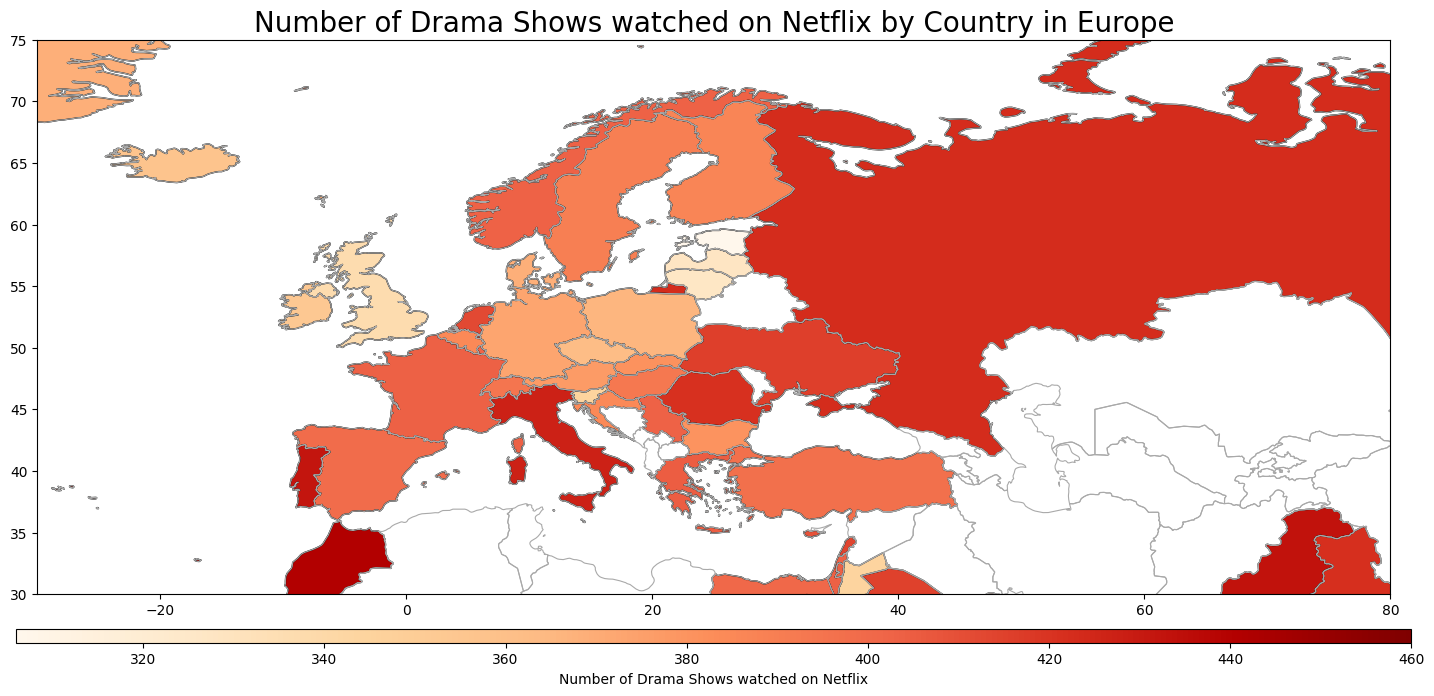

In [225]:
world = gpd.read_file('/Users/denyceng/CODE1161dataproject/ne_50m_admin_0_countries')

# merges the world GeoDataFrame with another DataFrame called dramatic_df. 
# The merge is done on the columns 'SOVEREIGNT' from world and 'country_name' from dramatic_df. 
# The how='left' argument means that all rows from the world dataset will be retained, and only matching rows from dramatic_df will be added
world = world.merge(dramatic_df, left_on='SOVEREIGNT', right_on='country_name', how='left') #

fig, ax = plt.subplots(1, 1, figsize=(18, 9)) #creates a Matplotlib figure (fig) and a set of axes (ax).
world.boundary.plot(ax=ax,edgecolor= 'darkgray',lw=0.8) #plots the boundaries of the geometries from GeoDataFrame on axes. This step outlines the countries borders.
world.plot(column='drama_count', #specifies the column in the GeoDataFrame to use for coloring the map. Here, it's likely a count of drama shows.
           ax=ax,
           legend=True, #adds a legend (colorbar) to the plot
           cmap='OrRd', #sets the colormap to "Orange-Red,"
           edgecolor='black',
           legend_kwds={'label': "Number of Drama Shows watched on Netflix",
                        'orientation': "horizontal",'pad':0.05, 'aspect':100, 'spacing':'proportional'}) # It sets the label of the colorbar and makes the orientation of the legend horizontal.
ax.tick_params(axis='both', labelsize=10) #sets the font size of the tick labels on X and Y axis to 45.
ax.set_ylim([30, 75]) 
ax.set_xlim([-30,80]) 
plt.title('Number of Drama Shows watched on Netflix by Country in Europe',fontsize=20)
plt.show()

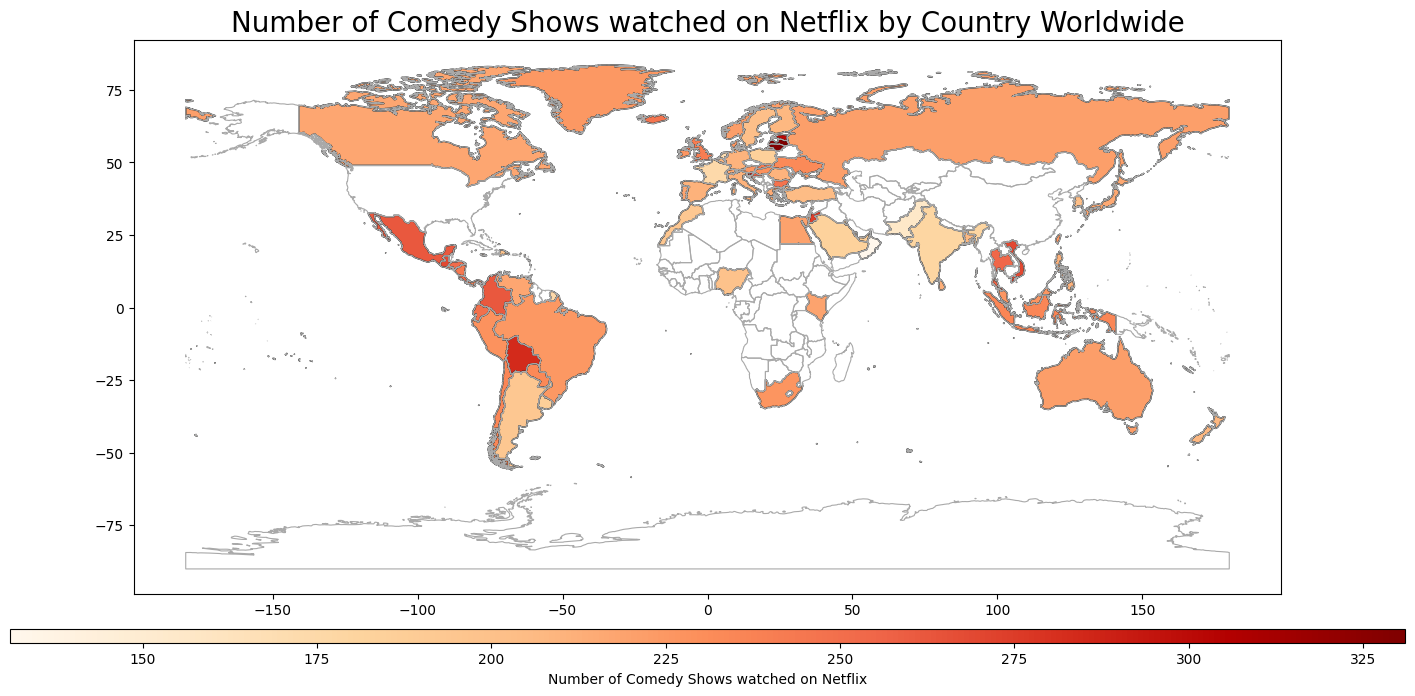

In [226]:
world = gpd.read_file('/Users/denyceng/CODE1161dataproject/ne_50m_admin_0_countries')

# merges the world GeoDataFrame with another DataFrame called dramatic_df. 
# The merge is done on the columns 'SOVEREIGNT' from world and 'country_name' from dramatic_df. 
# The how='left' argument means that all rows from the world dataset will be retained, and only matching rows from dramatic_df will be added
world = world.merge(funny_df, left_on='SOVEREIGNT', right_on='country_name', how='left') 

fig, ax = plt.subplots(1, 1, figsize=(18, 9)) #creates a Matplotlib figure (fig) and a set of axes (ax).
world.boundary.plot(ax=ax,edgecolor= 'darkgray',lw=0.8) #plots the boundaries of the geometries from GeoDataFrame on axes. This step outlines the countries borders.
world.plot(column='funny_count', #specifies the column in the GeoDataFrame to use for coloring the map. Here, it's likely a count of drama shows.
           ax=ax,
           legend=True, #adds a legend (colorbar) to the plot
           cmap='OrRd', #sets the colormap to "Orange-Red,"
           edgecolor='black',
           legend_kwds={'label': "Number of Comedy Shows watched on Netflix",
                        'orientation': "horizontal",'pad':0.05, 'aspect':100, 'spacing':'proportional'}) # It sets the label of the colorbar and makes the orientation of the legend horizontal.
ax.tick_params(axis='both', labelsize=10) #sets the font size of the tick labels on X and Y axis to 45.

plt.title('Number of Comedy Shows watched on Netflix by Country Worldwide',fontsize=20)
plt.show()


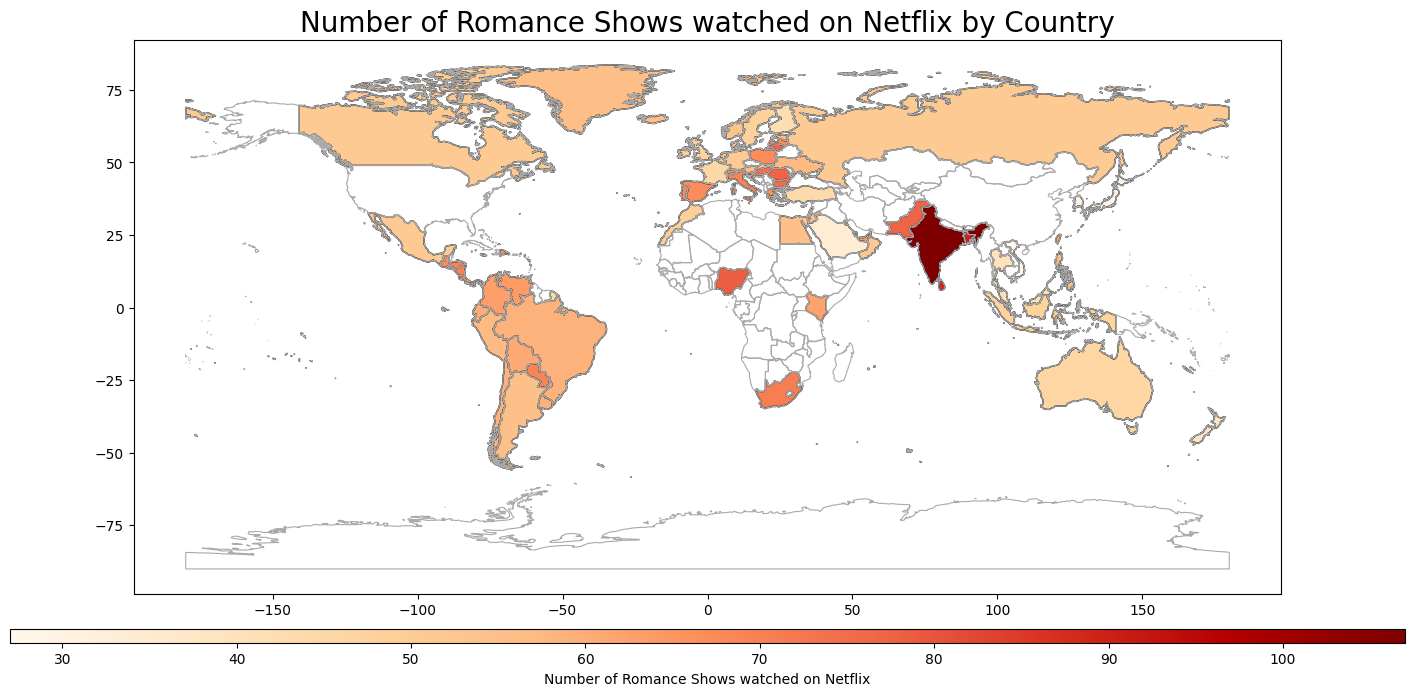

In [227]:

world = gpd.read_file('/Users/denyceng/CODE1161dataproject/ne_50m_admin_0_countries')

# merges the world GeoDataFrame with another DataFrame called dramatic_df. 
# The merge is done on the columns 'SOVEREIGNT' from world and 'country_name' from dramatic_df. 
# The how='left' argument means that all rows from the world dataset will be retained, and only matching rows from dramatic_df will be added
world = world.merge(romantic_df, left_on='SOVEREIGNT', right_on='country_name', how='left') #

fig, ax = plt.subplots(1, 1, figsize=(18, 9)) #creates a Matplotlib figure (fig) and a set of axes (ax).
world.boundary.plot(ax=ax,edgecolor= 'darkgray',lw=0.8) #plots the boundaries of the geometries from GeoDataFrame on axes. This step outlines the countries borders.
world.plot(column='romantic_count', #specifies the column in the GeoDataFrame to use for coloring the map. Here, it's likely a count of drama shows.
           ax=ax,
           legend=True, #adds a legend (colorbar) to the plot
           cmap='OrRd', #sets the colormap to "Orange-Red,"
           edgecolor='black',
           legend_kwds={'label': "Number of Romance Shows watched on Netflix",
                        'orientation': "horizontal",'pad':0.05, 'aspect':100, 'spacing':'proportional'}) # It sets the label of the colorbar and makes the orientation of the legend horizontal.
ax.tick_params(axis='both', labelsize=10) #sets the font size of the tick labels on X and Y axis to 45.

plt.title('Number of Romance Shows watched on Netflix by Country',fontsize=20)
plt.show()

## Let us look at India!

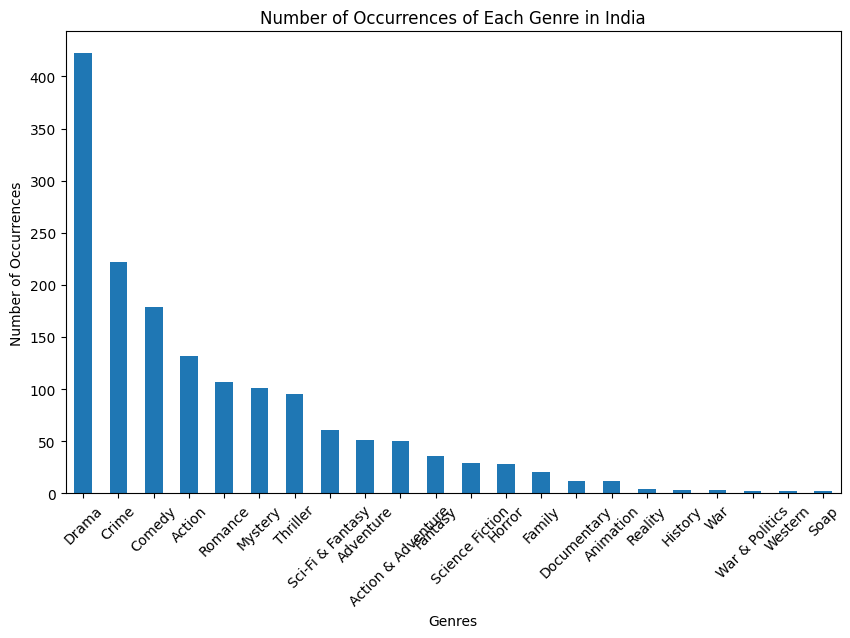

In [228]:
import matplotlib.pyplot as plt
from collections import Counter
import ast
from ast import literal_eval

pd.options.mode.chained_assignment = None 
country_name= 'India'
india_data = netflix_data[netflix_data['country_name'] == 'India']
# Create a list of all genres

all_genres = [genre for sublist in india_data['genres'] for genre in sublist]
# Count occurrences of each genre
genre_counts = pd.Series(all_genres).value_counts()

# Plot the bar chart
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.xlabel('Genres')
plt.ylabel('Number of Occurrences')
plt.title(f'Number of Occurrences of Each Genre in {country_name}')
plt.xticks(rotation=45)
plt.show()

pd.options.mode.chained_assignment = 'warn'

## What about the rest of the world?

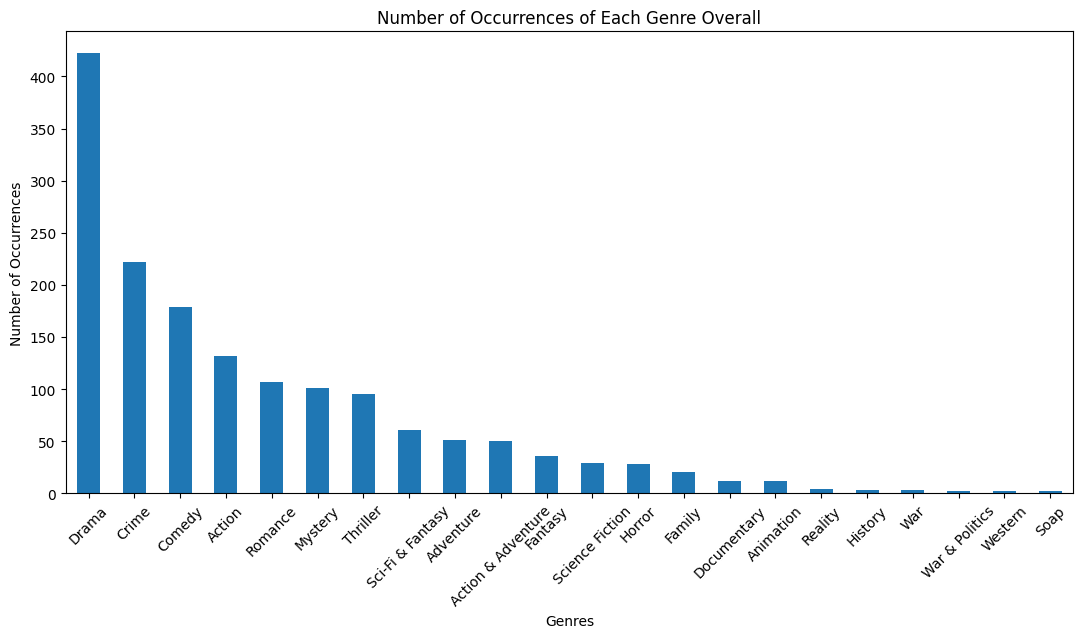

In [229]:


netflix_data['genres'] = netflix_data['genres'].apply(safe_eval)

# Create a list of all genres
all_genres = [genre for sublist in india_data['genres'] for genre in sublist]

# Count occurrences of each genre
genre_counts = pd.Series(all_genres).value_counts()

# Plot the bar chart
plt.figure(figsize=(13, 6))
genre_counts.plot(kind='bar')
plt.xlabel('Genres')
plt.ylabel('Number of Occurrences')
plt.title('Number of Occurrences of Each Genre Overall')
plt.xticks(rotation=45)
plt.show()